<h2>Applied Data Science Capstone Project - Battle of the Neighbourhoods</h2>

<p>For this 'Battle of the Neighbourhoods' Capstone Project, I will be looking at the London boroughs which
make up East London. A requirement of the project is to use the Foursquare Places API to produce place data for
a neighbourhood and comparing neighbourhoods with this information. I will be looking at parks in these boroughs.</p>

In [4]:
#install pandas v0.25 if current version is lower
#!pip install pandas==0.25 --force-reinstall --user 
import pandas as pd
import requests

In [5]:
#Get list of areas in London from this Wikipedia page and produce a dataframe with the data
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
df = (pd.read_html(url))[1]
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [2]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[3]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[3],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[3],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [6]:
#Drop unneeded columns
df.drop(df.columns[[2,4]], axis=1, inplace=True)
#Some column names are formatted incorrectly so correct these
df.rename(columns={'London\xa0borough': 'Borough', 'Postcode\xa0district': 'Postcode'}, inplace=True)
#Remove reference subscript 
df['Borough'] = df['Borough'].str.split('[').str[0]

In [7]:
#Keep only boroughs with mean house prices (2017) less than £500k
suitable = ['Barking and Dagenham', 'Bexley', 'Croydon', 'Ealing', 
            'Enfield', 'Greenwich', 'Havering', 'Hillingdon', 
           'Lewisham', 'Newham', 'Redbridge', 'Sutton', 'Waltham Forest']
s = set(suitable)
mask = df['Borough'].apply(lambda x: set(x.split(', ')).isdisjoint(s))
df = df[~mask]
df.dropna(subset=['OS grid ref'], inplace=True) 

In [8]:
#Install OSGridConverter for generating co-ordinates for places, using their OS grid reference.
!pip install OSGridConverter
#Latitude and Longitude for each place is stored in new columns.
from OSGridConverter import grid2latlong
df = df.assign(Latitude = '', Longitude = '')
for i in range(len(df)):
    df['Latitude'].iloc[i] = grid2latlong(df['OS grid ref'].iloc[i]).latitude
    df['Longitude'].iloc[i] = grid2latlong(df['OS grid ref'].iloc[i]).longitude

In [3]:
#Foursquare credentials imported. Hidden for pirvacy. Please enter your own if using. 

import json
filename = 'documents/fsquarecredential.json'
with open(filename) as f:
    data = json.load(f)
CLIENT_ID = data['credential']['CLIENT_ID'] #Foursquare )FS) ID
CLIENT_SECRET = data['credential']['CLIENT_SECRET'] # FS Secret
VERSION = data['credential']['VERSION'] # FS API version

In [10]:
#A HTTPS request is made to the Foursquare Places API  to get each park within a 1km radius of the co-ordinates 
#corresponding to a place in the dataframe. The resulting JSON is queried to store park names in a new column for
#each area. 

df = df.assign(Parks = '')
search_query = 'park'
radius = 1000
LIMIT = 150

for i in range(len(df)):
    latitude = df['Latitude'].iloc[i]
    longitude = df['Longitude'].iloc[i]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    for j in range(len(results['response']['venues'])):
        try:
            if results['response']['venues'][j]['categories'][0]['name'] == 'Park': 
                if df['Parks'].iloc[i] == '':
                    df['Parks'].iloc[i] += results['response']['venues'][j]['name']
                else:
                    df['Parks'].iloc[i] += ', ' + results['response']['venues'][j]['name']
        except: 
            results['response']['venues'][j]['categories'] == []
            
df.drop(['OS grid ref', 'Latitude', 'Longitude', 'Postcode'],axis=1, inplace=True)

In [11]:
#Pandas explode feature is used to expand the dataframe so that location have unique rows for each borough they're in
#and for each park in them.
df.Borough = df.Borough.str.split(',\s*')
df = df.explode('Borough')
df.Parks = df.Parks.str.split(',\s*') 
df = df.explode('Parks') 

#Numbers of unique parks in a borough and in a place/location are tallied.
a = df.groupby('Location').Parks.nunique()
b = df.groupby('Borough').Parks.nunique()

#A new dataframe is produced for the 

df2 = pd.DataFrame(data=b[0:], 
        index=b.keys())
df2.reset_index(inplace=True)

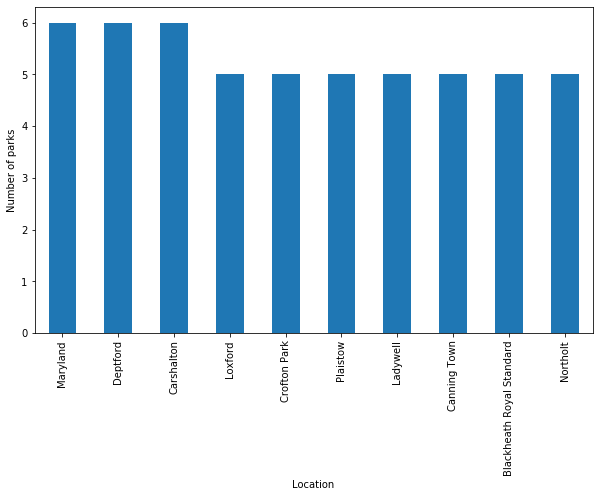

In [18]:
#Top 10 locations by number of parks is plotted.
import matplotlib.pyplot as plt
top10 = a.sort_values(ascending=False)[:10].plot(kind='bar')
plt.ylabel('Number of parks')
plt.show()

In [14]:
#Population Density by borough generated and inserted into a new dataframe. 

url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
df3 = (pd.read_html(url))[0]
df3['Borough'][0] = 'Barking and Dagenham'
mask = df3['Borough'].apply(lambda x: set(x.split(', ')).isdisjoint(s))
df3 = df3[~mask]
df3.drop(['Inner', 'Status', 'Local authority', 'Political control', 'Headquarters', 'Co-ordinates', 'Nr. in map'],axis=1, inplace=True)
df3['Population Density'] = df3[df3.columns[2]]/df3[df3.columns[1]]/10000
df3.drop([df3.columns[1], df3.columns[2]], axis=1, inplace=True)
df3['Borough'] = df3['Borough'].str.split('[').str[0]

/Users/ks/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
#This information is merged to produce a new datafame showing the accumulated number of parks 
#within 1km of areas in the borough, asw ell as population density for a borough.

merged_df = pd.merge(df2, df3, 
                     left_on = 'Borough', 
                     right_on = 'Borough', 
                     how='right')

merged_df

,Borough,Parks,Population Density
0,Barking and Dagenham,10,1.395205
1,Bexley,13,1.012348
2,Croydon,29,1.115690
3,Ealing,24,1.597453
4,Enfield,22,1.009842
5,Havering,21,0.558431
6,Hillingdon,25,0.642055
7,Lewisham,37,2.108917
8,Newham,29,2.276302
9,Redbridge,13,1.323563


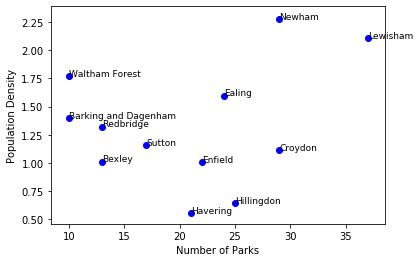

In [17]:
#This information is plot on a scatter plot

boroughs = merged_df['Borough'].values.tolist()
x_coords = merged_df['Parks'].values.tolist()
y_coords = merged_df['Population Density'].values.tolist()

for i,borough in enumerate(boroughs):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='o', color='blue')
    plt.text(x, y, borough, fontsize=9)
    plt.xlabel('Number of Parks')
    plt.ylabel('Population Density')
plt.rcParams['figure.figsize'] = [10, 6]
plt.show()

So what can be concluded from this data? The data seems to imply a positive correlation between number of parks and
population density of a borough. The areas with the most parks are all based in the most population dense boroughs of Hackney and Tower Hamlets. 

A person or family wanting to move to a borough on the basis of it having lots of available green space, might look to Havering with it being not so dense in population and having 21 parks. 
The size of these parks has not been looked at, however. As a next step, estimating the total area of these parks would make sense. It needs to be investigated also whether the Foursquare Places API is accurately picking up all parks in an area. 